In [14]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import utils
from tensorflow.keras import optimizers
from IPython.display import Image
import matplotlib.pyplot as plt
from keras.utils import plot_model
import matplotlib.cm as cm

In [1]:
preprocess_input = keras.applications.vgg16.preprocess_input
name_list = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

input_tensor = keras.Input(shape=(32, 32, 3))
resized_images = keras.layers.Lambda(lambda image: tf.image.resize(image, (224, 224)))(input_tensor)

vgg16 = tf.keras.applications.vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3), input_tensor=resized_images)
vgg16.trainable = True#False#True

x = vgg16.get_layer('block5_pool').output
x = keras.layers.Flatten(name='flatten')(x)
x = keras.layers.Dense(100, name='dense_1', activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)
output = keras.layers.Dense(10, name='dense_2', activation='softmax')(x)
model = keras.models.Model(inputs = vgg16.inputs, outputs=output)

model.summary()

Using TensorFlow backend.


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
lambda (Lambda)              (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584

In [2]:
img_size = (224, 224)

epochs = 10
batch_size = 32

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = preprocess_input(x_train[:2000])
y_train = utils.to_categorical(y_train[:2000], 10)

x_test = preprocess_input(x_test[:1000])
y_test = utils.to_categorical(y_test[:1000], 10)
print(x_train.shape)

model.compile(optimizer=optimizers.Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x=x_train, y=y_train,batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test), shuffle=True, verbose=1, workers=1) #,callbacks=callback
#dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


(2000, 32, 32, 3)
Epoch 1/10
63/63 [==============================] - 28s 440ms/step - loss: 2.2202 - accuracy: 0.2615 - val_loss: 1.5998 - val_accuracy: 0.4380
Epoch 2/10
63/63 [==============================] - 25s 404ms/step - loss: 1.5451 - accuracy: 0.4370 - val_loss: 1.4365 - val_accuracy: 0.4830
Epoch 3/10
63/63 [==============================] - 25s 404ms/step - loss: 1.3017 - accuracy: 0.5380 - val_loss: 1.2986 - val_accuracy: 0.5570
Epoch 4/10
63/63 [==============================] - 25s 404ms/step - loss: 0.9925 - accuracy: 0.6495 - val_loss: 1.1343 - val_accuracy: 0.5930
Epoch 5/10
63/63 [==============================] - 25s 404ms/step - loss: 0.7714 - accuracy: 0.7250 - val_loss: 1.5136 - val_accuracy: 0.5450
Epoch 6/10
63/63 [==============================] - 25s 404ms/step - loss: 0.6089 - accuracy: 0.7815 - val_loss: 1.2135 - val_accuracy: 0.5870
Epoch 7/10
63/63 [==============================] - 25s 404ms/step - loss: 0.4769 - accuracy: 0.8350 - val_loss: 1.3145 - va

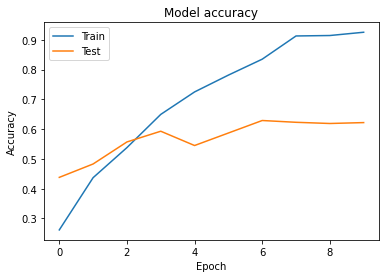

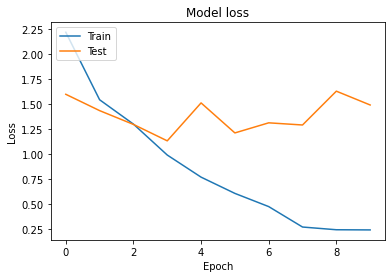

In [3]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [52]:
def get_gradcam(IMAGE_PATH, LAYER_NAME, CLASS_INDEX):
    img = tf.keras.preprocessing.image.load_img(IMAGE_PATH, target_size=(224, 224))
    img = tf.keras.preprocessing.image.img_to_array(img)

    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(LAYER_NAME).output, model.output])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(np.array([img]))
        print("Gound Truth: %s" % name_list[CLASS_INDEX])
        print("Predicted: %s" % (name_list[np.argmax(predictions)]))
        loss = predictions[:, CLASS_INDEX]

    output = conv_outputs[0]
    grads = tape.gradient(loss, conv_outputs)[0]

    gate_f = tf.cast(output > 0, 'float32')
    gate_r = tf.cast(grads > 0, 'float32')
    guided_grads = tf.cast(output > 0, 'float32') * tf.cast(grads > 0, 'float32') * grads

    weights = tf.reduce_mean(guided_grads, axis=(0, 1))

    cam = np.ones(output.shape[0: 2], dtype = np.float32)

    for i, w in enumerate(weights):
        cam += w * output[:, :, i]

    cam = cv2.resize(cam.numpy(), (224, 224))
    cam = np.maximum(cam, 0)
    heatmap = (cam - cam.min()) / (cam.max() - cam.min())
    cam = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
    out_name = IMAGE_PATH.split('.')[0] + '_' + LAYER_NAME + '.' + IMAGE_PATH.split('.')[1]
    
    output_image = cv2.addWeighted(cv2.cvtColor(img.astype('uint8'), cv2.COLOR_RGB2BGR), 0.5, cam, 1, 0)
    cv2.imwrite(out_name, output_image)
    
    return heatmap, img, cam, out_name
    

In [53]:
name_list = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
#             0,          1,            2,      3,     4,      5,     6,      7,       8,      9,
IMAGE_PATH = 'cat.jpg'
LAYER_NAME = 'block5_conv3'
CLASS_INDEX = name_list.index(IMAGE_PATH.split('.')[0])

Gound Truth: cat
Predicted: cat


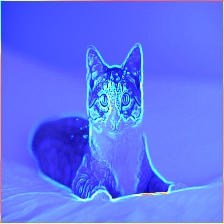

Gound Truth: cat
Predicted: cat


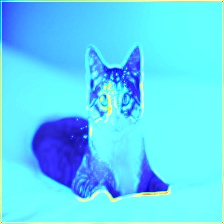

Gound Truth: cat
Predicted: cat


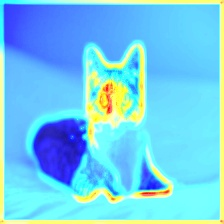

Gound Truth: cat
Predicted: cat


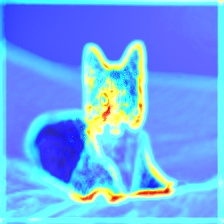

Gound Truth: cat
Predicted: cat


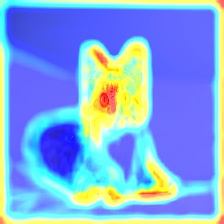

Gound Truth: cat
Predicted: cat


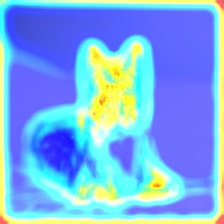

Gound Truth: cat
Predicted: cat


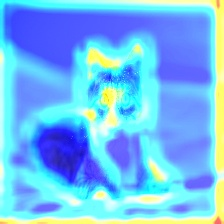

Gound Truth: cat
Predicted: cat


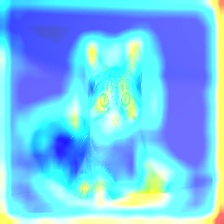

Gound Truth: cat
Predicted: cat


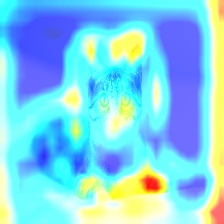

Gound Truth: cat
Predicted: cat


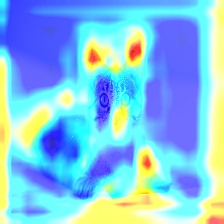

Gound Truth: cat
Predicted: cat


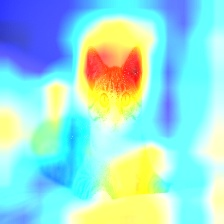

Gound Truth: cat
Predicted: cat


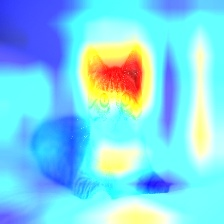

Gound Truth: cat
Predicted: cat


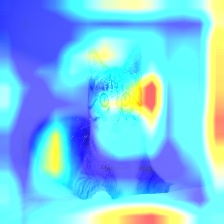

In [58]:
LAYER_NAMES = ['block1_conv1','block1_conv2','block2_conv1','block2_conv2','block3_conv1','block3_conv2','block3_conv3','block4_conv1','block4_conv2','block4_conv3','block5_conv1','block5_conv2','block5_conv3']
for LAYER_NAME in LAYER_NAMES:
    print(LAYER_NAME)
    heatmap, img, cam, out_name = get_gradcam(IMAGE_PATH, LAYER_NAME, CLASS_INDEX)
    display(Image(out_name))

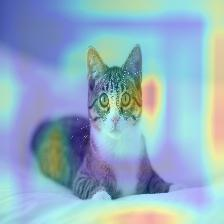

In [59]:
jet = cm.get_cmap("jet")
t_heatmap = np.uint8(255 * heatmap)
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[t_heatmap]

jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

superimposed_img = jet_heatmap * 0.4 + img
superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

save_path = "tttt.jpg"
superimposed_img.save(save_path)

display(Image(save_path))

In [46]:
#'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 
#'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 
#'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 
#'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 
#'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 
#'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 
#'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 
#'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 
#'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 
#'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 
#'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 
#'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 
#'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 
#'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 
#'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 
#'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'winter', 'winter_r'

#img = keras.preprocessing.image.load_img('frog.jpg')
#img = keras.preprocessing.image.img_to_array(img)

#heatmap = np.uint8(255 * heatmap)
